# Time series exploration

In [41]:
#imports
import json
import math
import folium
from src.SVY21 import SVY21
import geopandas as gpd
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
with open("./data/carpark_imputed_nonull.json", "r") as f:
    dataset = json.load(f)

In [3]:
carpark_list = []
for carpark in dataset:
    carpark_list.append(carpark)

In [4]:
#number of carparks
print(len(carpark_list))

1936


### Time series for a carpark

In [8]:
carpark_list[0]

'HE12'

In [5]:
#collect data
utilisation = dataset[carpark_list[0]]['util_pct']
time = dataset[carpark_list[0]]['timestamp']

In [6]:
#parse datestring
timestamp = [datetime.strptime(x[:-6], '%Y-%m-%dT%H') for x in time]

In [7]:
df = pd.DataFrame({'utilisation':utilisation})
df.index = timestamp

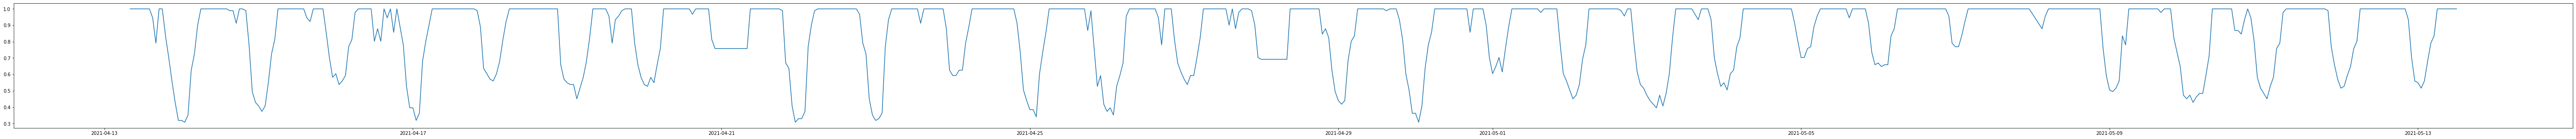

In [81]:
plt.figure(figsize=(100, 5))
plt.plot(df)
plt.savefig("EDA/example-timeseries.jpg")

#### Exploring changes with variables

In [8]:
#exploring daily average
day_of_week = [x.weekday() for x in timestamp]

In [9]:
df["day_of_week"] = day_of_week

In [10]:
daily_util = df.groupby("day_of_week").mean()
daily_util

,utilisation
day_of_week,
0,0.788198
1,0.873339
2,0.855142
3,0.854284
4,0.885146
5,0.890099
6,0.844135


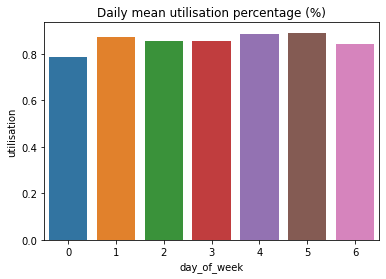

In [11]:
sns.barplot(x=daily_util.index, y=daily_util['utilisation'])
plt.title("Daily mean utilisation percentage (%)")
plt.savefig("EDA/daily-mean-util-pct.jpg")
plt.show()

There seems to be no difference in the utilisation percentages between days other than the noticeable decline in utilisation on monday (0)

In [12]:
#exploring hour of day
hour_of_day = [x.hour for x in timestamp]

In [13]:
df["hour"] = hour_of_day

In [14]:
hourly_util = df.groupby("hour").mean()
hourly_util

,utilisation,day_of_week
hour,,
0,0.531892,2.966667
1,0.515917,2.966667
2,0.544542,2.966667
3,0.637467,2.966667
4,0.756600,2.966667
5,0.816367,2.966667
6,0.937333,2.966667
7,0.953067,2.966667
8,0.976581,2.903226


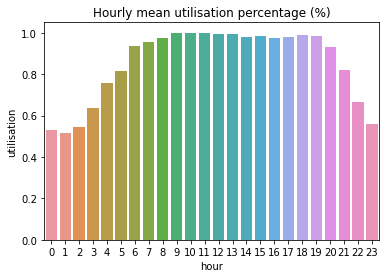

In [15]:
sns.barplot(x=hourly_util.index, y=hourly_util['utilisation'])
plt.title("Hourly mean utilisation percentage (%)")
plt.savefig("EDA/hourly-mean-util-pct.jpg")
plt.show()

There is low utilisation in the early hours and maximum utilisation between the hours of 9 and 6 (working hours)

## Plotting data on map

In [17]:
cv = SVY21()
lat, long = cv.computeLatLon(30069.2434, 26367.5806)

In [39]:
# map_sg = folium.Map(location=[lat,long], zoom_start=12)
# folium.Marker([lat,long]).add_to(map_sg)
# map_sg

## Day of weeks for more carparks

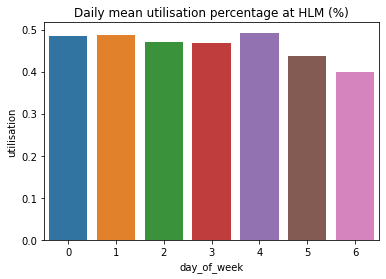

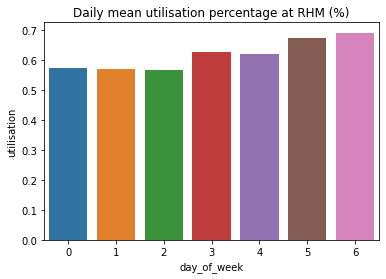

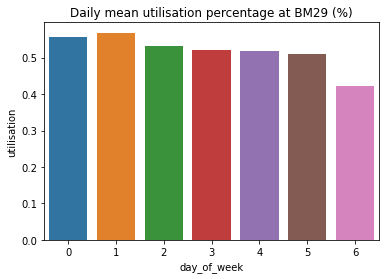

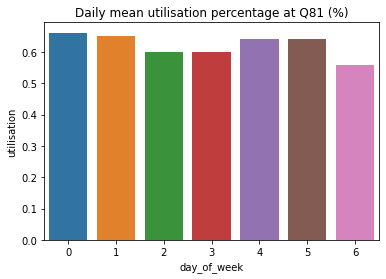

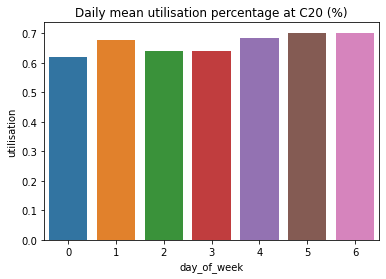

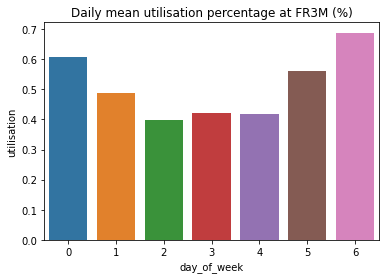

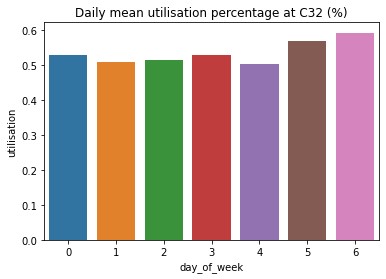

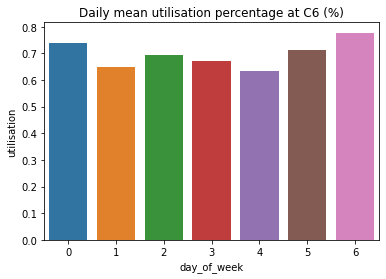

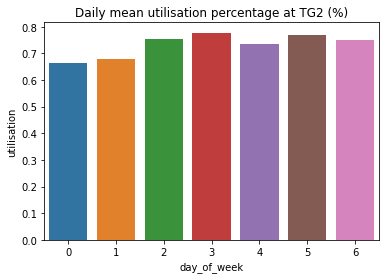

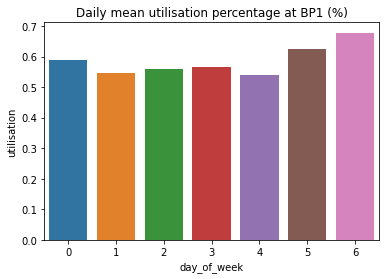

In [43]:
for each in carpark_list[1:11]:
    utilisation = dataset[each]['util_pct']
    time = dataset[each]['timestamp']
    timestamp = [datetime.strptime(x[:-6], '%Y-%m-%dT%H') for x in time]
    df = pd.DataFrame({'utilisation':utilisation})
    df.index = timestamp
    day_of_week = [x.weekday() for x in timestamp]
    df["day_of_week"] = day_of_week
    daily_util = df.groupby("day_of_week").mean()
    sns.barplot(x=daily_util.index, y=daily_util['utilisation'])
    plt.title(f"Daily mean utilisation percentage at {each} (%)")
    plt.show()

## Hour of day of more carparks

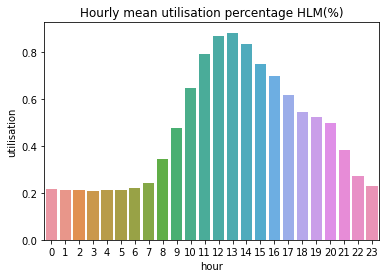

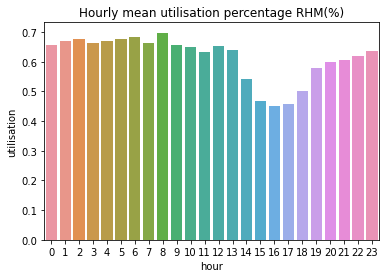

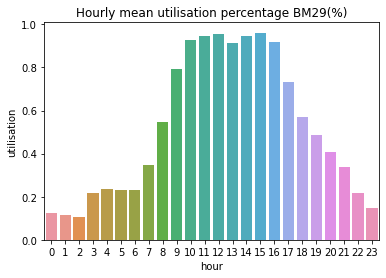

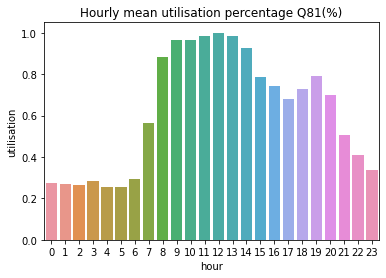

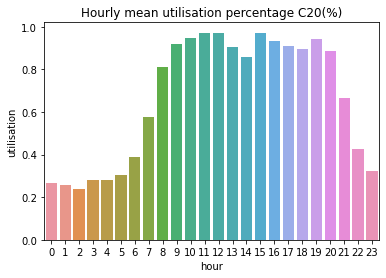

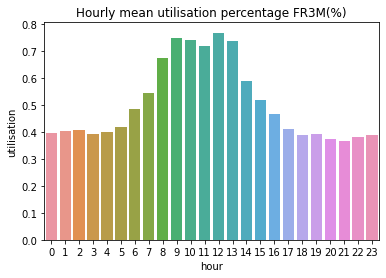

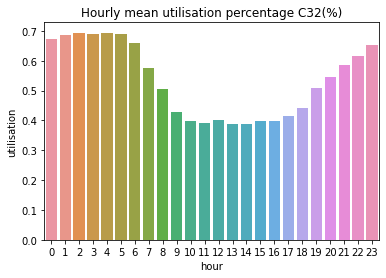

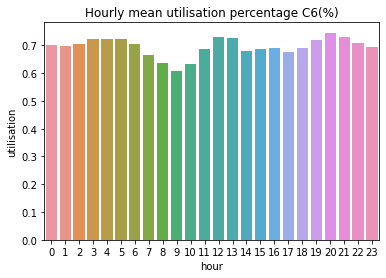

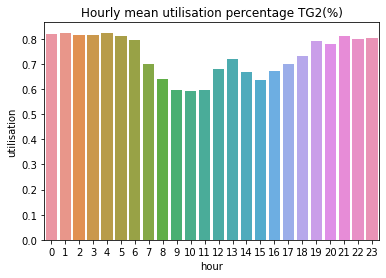

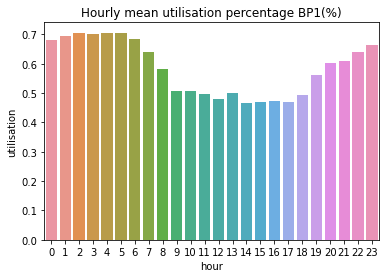

In [44]:
for each in carpark_list[1:11]:
    utilisation = dataset[each]['util_pct']
    time = dataset[each]['timestamp']
    timestamp = [datetime.strptime(x[:-6], '%Y-%m-%dT%H') for x in time]
    df = pd.DataFrame({'utilisation':utilisation})
    df.index = timestamp
    hour_of_day = [x.hour for x in timestamp]
    df["hour"] = hour_of_day
    hourly_util = df.groupby("hour").mean()
    sns.barplot(x=hourly_util.index, y=hourly_util['utilisation'])
    plt.title(f"Hourly mean utilisation percentage {each}(%)")
    plt.show()

In [48]:
#plotting FR3M and C32
#reading coord data
coord_df = pd.read_csv("data/hdb-carpark-information.csv")
FR3M_coords = [coord_df[coord_df['car_park_no'] == 'C32']['y_coord'], coord_df[coord_df['car_park_no'] == 'C32']['x_coord']]
lat, long = cv.computeLatLon(FR3M_coords[0], FR3M_coords[1])
map_sg = folium.Map(location=[lat,long], zoom_start=12)
folium.Marker([lat,long]).add_to(map_sg)
map_sg

## Dealing with missing value

Our data is missing 1 date in the 30 days we have recorded.

In [18]:
#for each timestamp after the first, check if timestamp is 1 hour ahead of the previous timestamp
for timestamp in range(1, len(df.index)):
    if df.index[timestamp] - pd.DateOffset(hours=1) != df.index[timestamp - 1]:
        print(df.index[timestamp])
        print(timestamp)

2021-05-08 03:00:00
592


In [19]:
df.index[[591,592]]

DatetimeIndex(['2021-05-07 23:00:00', '2021-05-08 03:00:00'], dtype='datetime64[ns]', freq=None)

There is a gap of 3 hours of data missing from all carpark data. Impute

In [59]:
#inserts timestamp data into missing 3 hours
for carpark in carpark_list:
    for dex in range(len(dataset[carpark]["timestamp"])-2):
        #parse string to date
        required_stamp = datetime.strptime(dataset[carpark]["timestamp"][dex], '%Y-%m-%dT%H:%M:%S') + timedelta(hours=1)
        actual_stamp = datetime.strptime(dataset[carpark]["timestamp"][dex+1], '%Y-%m-%dT%H:%M:%S')
        if required_stamp !=  actual_stamp:
            dataset[carpark]["timestamp"].insert(dex+1, required_stamp.strftime('%Y-%m-%dT%H:%M:%S'))
            dataset[carpark]["util_pct"].insert(dex+1, np.nan)

In [60]:
with open("./data/carpark_imputed.json", "w") as f:
    json.dump(dataset, f)

### Imputation

In [61]:
with open("./data/carpark_imputed.json", "r") as f:
    dataset = json.load(f)

In [62]:
#using pandas .interpolate() method to insert util_pct
for carpark in carpark_list:
    interpolate_df = pd.DataFrame({'util_pct':dataset[carpark]["util_pct"]})
    dataset[carpark]["util_pct"] = list(interpolate_df.interpolate()["util_pct"])

In [63]:
with open("./data/carpark_imputed_nonull.json", "w") as f:
    json.dump(dataset, f)

## Converting SVY21 coordinate system to LatLon

In [17]:
from src.SVY21 import SVY21

In [18]:
cv = SVY21()

In [22]:
#cv.computeLatLon(y-coord/x-coord)
cv.computeLatLon(30069.2434, 26367.5806)

(1.2882093564649053, 103.81865029073313)